<a href="https://colab.research.google.com/github/benmsanderson/prpattern/blob/main/CMIP6_get_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4xCO2 read data


CMIP6

In [39]:
src=['CESM2','CanESM5']

In [8]:
flds=['tas']

In [113]:
datadir='./download'
import os
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [12]:
expts=['1pctCO2','abrupt-4xCO2','piControl','historical','ssp126','ssp585']
calstrt=[True,True,True,False,False,False]
dbe=['CMIP','CMIP','CMIP','CMIP','ScenarioMIP','ScenarioMIP']

In [3]:
import xarray as xr
import xesmf as xe
import numpy as np

In [75]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
from netCDF4 import num2date
import gcsfs
import cftime
from itertools import product



Define output resolution

In [22]:
ds_out = xe.util.grid_2d(-180.0, 180.0, 2.5, -90.0, 90.0, 2.5)

## Browse Catalog

The data catatalog is stored as a CSV file. Here we read it with Pandas.

In [37]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv', low_memory=False)

Variables and experiments in database

Make dataframe for each experiment type and each field

In [38]:
vars=df.variable_id.unique()
vars.sort()

expts_full=df.experiment_id.unique()
expts_full.sort()

flds_full=df.variable_id.unique()
flds_full.sort()

src_full=df.source_id.unique()
src_full.sort()
src_full

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-HR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'CAS-ESM2-0', 'CESM1-1-CAM5-CMIP5', 'CESM1-WACCM-SC', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-CM2-VHR4', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA',
       'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-LR',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'EC-Earth3P', 'EC-Earth3P-HR',
       'EC-Earth3P-VHR', 'ECMWF-IFS-HR', 'ECMWF-IFS-LR', 'FGOALS-f3-H',
       'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-ESM4', 'GFDL-OM4p5B',
       'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G',
       'GISS-E2-2-H', 'HadGEM3-GC31-HM', 'HadGEM3-GC31-LL',
       'HadGEM3-GC31-LM', 'HadGEM3-GC31-MM',

In [13]:
df_all1=[]
for i, row in enumerate(expts):
  df_ta1=[]
  for j,fld in enumerate(flds):
    tmp = df.query("activity_id=='"+dbe[i]+"' & table_id == 'Amon' & variable_id == '"+fld+"' & experiment_id == '"+expts[i]+"'")
    df_ta1.append(tmp)
  df_all1.append(df_ta1)

Make some empty dataframes to store concise list

In [14]:
cnames=df_all1[0][0].columns
df_all=[]
for i, exp in enumerate(expts):
  tmp=[]
  for j,fld  in enumerate(flds):
    tmp.append(pd.DataFrame(columns=cnames))
  df_all.append(tmp)

Now get 1 ensemble member for each model, if it exists, for each experiment.  Only add to dataframe df_ta if we have a full set of experiments

In [40]:
mdls=[]
n=0
for j, mdl in enumerate(src):
    tmpdf=[]
    nruns=[]
    for i, ext in enumerate(expts):
        #find first variable for expt/model
        for j, fld in enumerate(flds):
          tmp=df_all1[i][j].query("source_id=='"+mdl+"'")
          nruns.append(tmp.shape[0])
    #is there at least 1 run per experiment,with all fields?
    if min(nruns)>=1:
      #point to the entry for 1st run, first variable for each expt
      for i, ext in enumerate(expts):
        mmb=df_all1[i][0]['member_id'].values[0]
        for j, fld in enumerate(flds):
          tt = df_all1[i][j].query("source_id=='"+mdl+"' & table_id == 'Amon'")
          df_all[i][j].loc[n]=tt.values[0]
      #add model to final list
      mdls.append(mdl)
      n=n+1
    else:
        print(mdl+' does not have all required simulations')
mdls
    

['CESM2', 'CanESM5']

## Load Data

Load Google file system


In [18]:
# load Google cloud storage
gcs = gcsfs.GCSFileSystem(token='anon')

Loop through zstore links, use zarr to open


In [42]:

if readdata:
  dsall=[]
  for i,df_ta in enumerate(df_all):

    dsm=[]
    for j,df in enumerate(df_ta):
      ds=[]
      print(expts[i]+','+flds[j])
      for index, item in enumerate(df.zstore.values, start=0):
        mapper=gcs.get_mapper(item)
        ds.append(xr.open_zarr(mapper, decode_times=False))
      dsm.append(ds)
    dsall.append(dsm)  

1pctCO2,tas
abrupt-4xCO2,tas
piControl,tas
historical,tas
ssp126,tas
ssp585,tas


concatenated dataarrays for ts, global mean


In [109]:
 
if readdata:
  dall=[]
  for i,ds in enumerate(dsall,start=0):
    dexp=[]
    for j,dm in enumerate(ds):
      print(expts[i]+','+flds[j])
      srcls=[]  
      for index, dd in enumerate(dm, start=0):
          regridder = xe.Regridder(dd, ds_out, 'bilinear', periodic=True)
          #tmp=dd[flds[j]][:4800,:,:].interp(lon=lon_out,lat=lat_out, kwargs={"fill_value": "extrapolate"})
          tmp = regridder(dd)
          if calstrt[i]:
            dates = [cftime.DatetimeNoLeap(year, month, 1) for year, month in product(range(0, int(tmp['time'].values.shape[0]/12)), range(1, 13))]
            tmp.coords['time']=dates
          if tmp['time'].dtype=='float64' or  tmp['time'].dtype=='int64':
            tmp.coords['time']=num2date(tmp['time'].values,dd['time'].units)     
          srm=tmp.groupby('time.year').mean('time')
          
          if index==0:
            dac=srm
          else:
            dac=xr.concat([dac,srm],'ens',coords='minimal',compat='override')
          srcls.append(dd.source_id)
      dac=dac.assign_coords(ens=srcls)   
      dexp.append(dac)
    dall.append(dexp)

1pctCO2,tas
abrupt-4xCO2,tas
piControl,tas
historical,tas
ssp126,tas
ssp585,tas


Find complete runs




In [114]:

if readdata:
  for i,d in enumerate(dall,start=0):
    tmp=xr.merge(d[:])
    tmp.to_netcdf(datadir+'/'+expts[i]+'.nc')



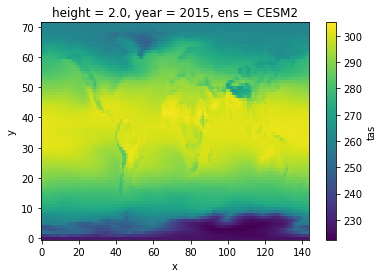

In [121]:
tmp['tas'][0,1,:,:].plot()